In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from lifetimes.utils import summary_data_from_transaction_data
import seaborn as sns
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter, GammaGammaFitter
import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### Change timestamp to ISO

In [2]:
# def preprocess_events_data(df):
#     """
#     Preprocesses the events DataFrame.
#     Converts 'timestamp' to datetime and creates a 'date' column.
#     """
#     df["ISO datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
#     df["date"] = df["ISO datetime"].dt.date
#     return df

# def preprocess_item_properties_data(df):
#     """
#     Preprocesses the item properties DataFrame.
#     Converts 'timestamp' to datetime and creates a 'date' column.
#     """
#     df["ISO datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
#     df["date"] = df["ISO datetime"].dt.date
#     return df

# # events = pd.read_csv("../dataset/events.csv")
# # events_processed = preprocess_events_data(events.copy())
# # events_processed.to_csv("../dataset/events_processed.csv", index=False)

# # item_properties_part_1_df = pd.read_csv("../dataset/item_properties_part1.csv")
# # item_properties_part_1_df_processed = preprocess_item_properties_data(item_properties_part_1_df.copy())

# # item_properties_part_2_df = pd.read_csv("../dataset/item_properties_part2.csv")
# # item_properties_part_2_df_processed = preprocess_item_properties_data(item_properties_part_2_df.copy())

# # item_properties_processed = pd.concat([item_properties_part_1_df_processed, item_properties_part_2_df_processed])
# # item_properties_processed.head()


In [3]:
try:
    event_df = pd.read_csv('../dataset/events.csv')
    item_df = pd.read_csv('../dataset/item_properties.csv')
    category_df = pd.read_csv('../dataset/category_tree.csv')
    print("Data Loaded Successfully!")
except FileNotFoundError:
    print("❌ File not found. Please check the path.")
    

Data Loaded Successfully!


## 1. Data cho K-means (cần RFM, conversion rate (category))

* Change property 790 to prices

In [4]:
prices = item_df[item_df['property'] == '790'].copy()
prices['price'] = prices['value'].apply(lambda x: float(x.replace('n', '')))
prices = prices[['itemid', 'timestamp', 'price']].sort_values('timestamp')


In [5]:
# ghép bảng giao dịch với giá tiền gần nhất trong bảng item
event_df = event_df.sort_values('timestamp')
event_df_price = pd.merge_asof(
    event_df,
    prices,
    left_on='timestamp',
    right_on='timestamp',
    by='itemid',
    direction='nearest', # Hoặc backward
    tolerance=pd.Timedelta('100000 days').value // 1000000 # convert days to ms nếu timestamp là ms
)
# thêm cột datetime, set time hiện tại = max + 1
if 'timestamp' in event_df_price.columns:
    event_df_price['datetime'] = pd.to_datetime(event_df_price['timestamp'], unit='ms')
current_date = event_df_price['datetime'].max() + pd.Timedelta(days=1)


* fill price = mean

In [6]:
global_avg_price = event_df_price['price'].mean()
event_df_price['price'] = event_df_price['price'].fillna(global_avg_price)

* Calculating R,F,M, prepare for K-means. Add more features 

In [7]:
event_df_price['is_view'] = (event_df_price['event'] == 'view').astype(int)
event_df_price['is_cart'] = (event_df_price['event'] == 'addtocart').astype(int)
event_df_price['is_buy']  = (event_df_price['event'] == 'transaction').astype(int)

# tính giá trị 
event_df_price['revenue'] = event_df_price['price'] * event_df_price['is_buy'] 
# event_df_price['view_value'] = event_df_price['price'] * event_df_price['is_view'] # Để tính trung bình giá các món họ xem
event_df_price.head(2)


,timestamp,visitorid,event,itemid,transactionid,price,datetime,is_view,is_cart,is_buy,revenue
0,1430622004384,693516,addtocart,297662,NaN,14280.0,2015-05-03 03:00:04.384,0,1,0,0.0
1,1430622011289,829044,view,60987,NaN,204120.0,2015-05-03 03:00:11.289,1,0,0,0.0


* Group infomation by visitor_id. Remove visitor no transactions

In [8]:
user_profile = event_df_price.groupby('visitorid').agg({
    'datetime': lambda x: (current_date - x.max()).days, # Recency (lần cuối tương tác bất kỳ)
    'is_view': 'sum',      # Tổng lượt xem
    'is_cart': 'sum',      # Tổng lượt thêm giỏ
    'is_buy': 'sum',       # Frequency (Số đơn mua)
    'revenue': 'sum',      # Monetary (Tổng tiền chi)
}).reset_index()


In [9]:
user_profile.columns = ['visitorid', 'Recency', 'View_Count', 'Cart_Count', 'Frequency', 'Monetary']
# recency là lần cuối tương tác bất kỳ, không nhất thiết phải mua

In [10]:
# Feature Enrichment: Tính các chỉ số phái sinh
# Conversion Rate: Tỷ lệ Mua / (Xem + Cart), smooth = +1
user_profile['Conversion_Rate'] = user_profile['Frequency'] / (user_profile['View_Count'] + user_profile['Cart_Count'] + 1)
user_profile.fillna(0, inplace=True)
print("Shape:", user_profile.shape)
user_profile[(user_profile['Frequency'] == 0) & (user_profile['Monetary'] != 0)]

Shape: (1407580, 7)


,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Conversion_Rate


In [11]:
customers_df = user_profile[user_profile['Monetary'] > 0].copy()
visitors_df = user_profile[user_profile['Monetary'] <= 0].copy()
customers_df.reset_index(drop=True, inplace=True)
customers_df

,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Conversion_Rate
0,172,35,33,3,2,99600.0,0.054054
1,186,37,2,1,1,59880.0,0.250000
2,264,11,3,2,2,94056.0,0.333333
3,419,51,4,1,1,17160.0,0.166667
4,539,94,4,2,1,34920.0,0.142857
...,...,...,...,...,...,...,...
11714,1406787,108,20,0,1,54000.0,0.047619
11715,1406981,123,4,1,1,143880.0,0.166667
11716,1407070,127,1,3,1,79080.0,0.200000
11717,1407110,45,7,1,1,20400.0,0.111111


In [12]:
cols_features = [
    'Recency', 
    'Frequency', 
    'Monetary', 
    'Conversion_Rate' 
]
print("Feature's Skewness")
print(customers_df[cols_features].skew())

Feature's Skewness
Recency             0.100507
Frequency          34.970714
Monetary           34.596136
Conversion_Rate     4.890277
dtype: float64


* Standarization

In [38]:
customer_transformed = customers_df.copy()
id_col = 'visitorid'

# Chỉ log các biến scale lớn & skew nặng
cols_to_log = ['Frequency', 'Monetary']
# Conversion_Rate thường [0,1] → KHÔNG cần log
# Recency thường skew thấp → giữ nguyên

customer_transformed[cols_to_log] = np.log1p(
    customer_transformed[cols_to_log]
)

print("--- Skewness sau log1p ---")
print(customer_transformed[['Recency','Frequency','Monetary','Conversion_Rate']].skew())

--- Skewness sau log1p ---
Recency            0.100507
Frequency          4.870120
Monetary           0.532453
Conversion_Rate    4.890277
dtype: float64


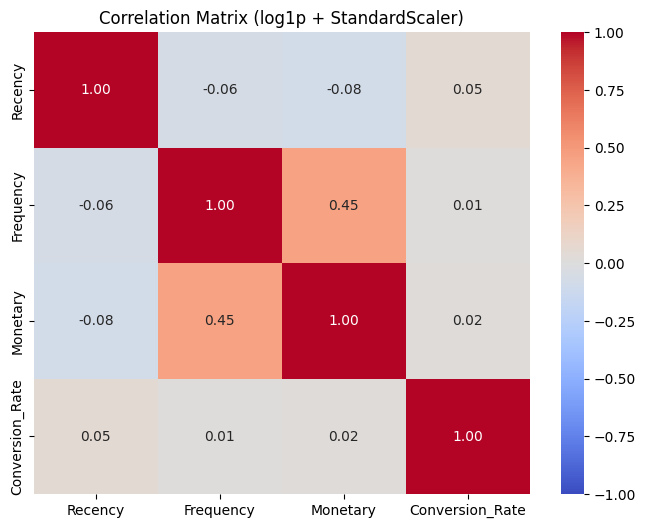

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_transformed[cols_features])

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=cols_features,
    index=customer_transformed.index
)

# Heatmap
plt.figure(figsize=(8,6))
corr_matrix = X_scaled_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix (log1p + StandardScaler)")
plt.show()

X_scaled_df.insert(0, 'visitorid', customer_transformed[id_col].values)

In [40]:
X_scaled_df.to_csv('../dataset/user_scaled.csv', index=False)
customers_df.to_csv('../dataset/customers.csv', index=False)

## 2. Data cho CLV (cần RFM riêng)
* f:số lần mua lặp lại (freq-1)
* r: khoảng cách từ lần mua đầu đến lần cuối != kcach lần cuối đến hiện tại
* t: khoảng cách từ lần mua đầu đến hiện tại

In [28]:
event_df_price.head()
event_df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   price          float64       
 6   datetime       datetime64[ns]
 7   is_view        int64         
 8   is_cart        int64         
 9   is_buy         int64         
 10  revenue        float64       
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 231.3+ MB


In [35]:
clean_transaction_log = event_df_price[event_df_price['transactionid'].notnull()][['visitorid', 'datetime', 'price']].copy()
clean_transaction_log.rename(columns={
    'datetime': 'date', 
    'price': 'monetary_value'
}, inplace=True)

clv_data = summary_data_from_transaction_data(
    clean_transaction_log,
    'visitorid',
    'date',
    monetary_value_col='monetary_value',
    observation_period_end='2015-09-18' # Ngày cuối cùng trong dataset RetailRocket
)

print(f"Dữ liệu summary có {len(clv_data)} khách hàng.")
clv_data.tail(15)

Dữ liệu summary có 11719 khách hàng.


,frequency,recency,T,monetary_value
visitorid,,,,
1404894,0.0,0.0,10.0,0.0
1404991,0.0,0.0,88.0,0.0
1405688,0.0,0.0,93.0,0.0
1405714,0.0,0.0,125.0,0.0
1405831,0.0,0.0,77.0,0.0
1405861,0.0,0.0,121.0,0.0
1405929,0.0,0.0,15.0,0.0
1406087,0.0,0.0,108.0,0.0
1406564,0.0,0.0,23.0,0.0


In [37]:
clv_data.to_csv('../dataset/clv_data.csv')

Trung bình số ngày giữa 2 lần mua: 14.1 ngày
Trung vị số ngày giữa 2 lần mua: 5.7 ngày
